# <span style='font-family:Verdana;color:red;line-height:40px'>NYPD Crime Statistics</span>



## <span style='font-family:Verdana;color:navy;line-height:40px'>Data Engineering Capstone Project</span>

</br>

## <span style='font-family:Verdana;color:red;line-height:40px'>Project Summary</span>
The focus of this project is the analysis of statistical data collected by the New York City Policy (NYPD). The data has been download from the `data.gov ` website and it is analysed for the purpose of buliding ETL pipline for the final project in Data Engineering nano-degree. 

Downloaded data comprise of four `csv` datasets, and it entails the information on shootings, calls, arrests and subburbs (used for data enrichment). The use of this data is for analytical prupose, and it is out of the scope of this project to anticipate other possibility for using this data. For the purpose of this project, the focus is on preparing the data for a visual presentation or further analysis using machine learning. 

This excercise aims at developing ETL pipeline to organise data suitable for building dashboard similar to the one used by the [NYPD](https://data.cityofnewyork.us/Public-Safety/NYPD-Historic-Arrests-Summary-Dashboard/is7e-8exf).

## <span style='font-family:Verdana;color:navy;line-height:40px'>Steps</span>
The scope of the project consist of the following:
- [x] data exploration and analysis
- [x] data modeling and development 
- [x] data model testing 
- [x] pipeline testing
## <span style='font-family:Verdana;color:navy;line-height:40px'>Scope</span>
The project follows the follow steps:
* [Step 1](#Step-1:-Scope-the-Project-and-Gather-Data): Collect data files from [data.gov](https://data.gov/)
* [Step 2](#Step-2:-Explore-and-Assess-the-Data): Explore and assess the data
* [Step 3](#Step-3:-Define-the-Data-Model): Define the Data Model
* [Step 4](#Step-4:-Run-Pipelines-to-Model-the-Data): Run Pipelines to Model the Data  
* [Step 5](#Step-5:-Complete-Project-Write-Up): Complete Project Write Up
* [Resources](#Resources)
* [Continue](#CONTINUE)

# <span style='font-family:Verdana;color:navy;line-height:40px'>Step 1: Scope the Project and Gather Data</span>
Data used for the final project is found and downloaded from `data.gov` website. This data contains statistics collected by the NYPD. 

## <span style='font-family:Verdana;color:gray;line-height:40px'>Describe and Gather Data</span>
The data for this project is downloaded from the [data.gov](https://catalog.data.gov/dataset?q=NYPD) website and it is stored within a [Docker](#Docker) image for exploration and modeling. The following datasets are used for this purpose. 
 **[Shootings](#Shootings)** | **[Calls](#Calls)** |  **[Arrests](#Arrests)** | **[Suburbs](#Suburbs)**

---
## <span style='font-family:Verdana;color:gray;line-height:40px'>Libraries used for analysis</span>
---
[Project Summary](#Project-Summary)

In [1]:
import os
import re
import sys
import time
import datetime
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/opt/airflow/project/')
from etl.utils.base import WattleUtils
from etl.utils.sqlalchemy import WattleSqlAlchemy
from etl.utils.postgres import WattlePostgres

def log(text):
    current_time = datetime.datetime.now()
    milliseconds = current_time.microsecond // 1000
    formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    log_message = f"{formatted_time}.{milliseconds}: {text}"
    print(log_message)

cfg = {'host': 'localhost', 'port': 5432, 'user': 'airflow', 'pswd': 'airflow', 'dbname': 'postgres', 'verbose': False}

def execute(sql, table_name=None, column=None, value=None):
    try:
        wp = WattlePostgres(**cfg)
        rows = wp.execute(sql); wp.commit(); wp.close();
        if table_name is None:
            log('SQL successfully executed: ({:,}) rows.'.format(rows))
            return
        #pd.set_option('display.max_colwidth', 1000)
        where = "" if column is None or value is None else f" WHERE {column} = '{value}"
        df = select(f"EXPLAIN ANALYZE SELECT * FROM {table_name} {where};", False)
        log(','.join(df.iloc[1])); return
    except Exception as e:
        msg = "Parameters must be supplied to execute(table_name, column, value)."
        log('Error:{}\n{}'.format(msg,e))

def select(sql, inrows=None):
    start = time.time()
    alc = WattleSqlAlchemy(**cfg)
    df = alc.query(sql); alc.close(); 
    end = time.time();
    print(WattleUtils.get_dataframe_details(df, end - start, inrows) )
    return df

def show_uniques_values(df, key, items=5, spaces=18):
    text = WattleUtils.get_field_unique_values(df, key, items, spaces)
    print(text)

def show_missing_values(nulls, show_nulls=True, x=4, y=3):
    nulls = nulls[nulls > 0]
    if nulls.empty: 
        print(f'There are no missing values found.'); return;
    line()
    print(f"Missing values\n")
    if show_nulls: print(nulls.to_string());
    line()
    nulls = nulls.to_frame().rename_axis('Field'); nulls = nulls.rename(columns={0: 'Count'});nulls = nulls.reset_index(); 
    nulls = nulls.astype(str); nulls['Count'] = nulls['Count'].astype(int)
    sns.set(style="whitegrid"); plt.figure(figsize=(x,y));
    sns.barplot(y="Field", x="Count", data=nulls);plt.ylabel("Field names");plt.xlabel("Missing values")
    plt.show()

def show_additional_entries(df, key, duplicates):
    total = df.shape[0]
    uniques = len(df[key].unique())
    print("{} records found with {} unique keys.\n{} keys found with {} records, having {} extra entries.".format(
        total, uniques,
        duplicates.shape[0], duplicates['duplicates'].sum(), 
        total - uniques,
    ))
    duplicates.head(3)

def line():
    print("_" * 80)
    
log("Helper libraries intialised.")

2023-07-10 19:52:46.147: Helper libraries intialised.


# <span style='font-family:Verdana;color:red;line-height:40px'>Shootings</span>

This dataset provides statistical information on incidents resulting from shootings in the New York area. The data has been collected from the NYPD and includes details about the time and location of the incidents, as well as demographic information about both the perpetrator and the shooting victim.

[Top](#Project-Summary) |
[data.gov](https://catalog.data.gov/dataset/nypd-shooting-incident-data-year-to-date) |
[Analysis](#Analysis:-staging_shootings)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,264689062,03/07/2023,21:32:00,MANHATTAN,INSIDE,30,0,DWELLING,MULTI DWELL - APT BUILD,Y,...,M,BLACK,25-44,M,BLACK,999923,241388,40.829217,-73.943363,POINT (-73.943363 40.829217)


RECORDS: 292
________________________________________________________________________________
BORO               : [BRONX, BROOKLYN, MANHATTAN, QUEENS, STATEN ISLAND] of (5) values.
LOC_OF_OCCUR_DESC  : [INSIDE, OUTSIDE] of (2) values.
LOC_CLASSFCTN_DESC : ['(null)', 'COMMERCIAL', 'DWELLING', 'HOUSING', 'OTHER'] of (8) values.
PERP_AGE_GROUP     : ['(null)', '1028', '18-24', '25-44', '45-64'] of (6) values.
PERP_SEX           : [(null), F, M] of (3) values.
PERP_RACE          : ['(null)', 'ASIAN / PACIFIC ISLANDER', 'BLACK'] of (6) values.
VIC_AGE_GROUP      : [18-24, 25-44, 45-64, 65+, <18] of (5) values.
VIC_SEX            : [F, M] of (2) values.
VIC_RACE           : [ASIAN / PACIFIC ISLANDER, BLACK, BLACK HISPANIC, WHITE, WHITE HISPANIC] of (5) values.
________________________________________________________________________________
Missing values

Latitude                    11
Longitude                   11
New Georeferenced Column    11
____________________________________________

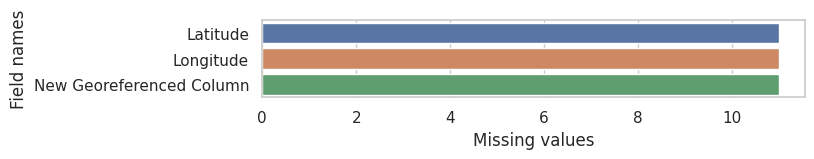

In [2]:
import pandas as pd
shootings = pd.read_csv('/home/airflow/data/NYPD_Shooting_Incident_Data__Year_To_Date_.csv') # SHOOTINGS
display(shootings.head(1))
print('RECORDS: {:,}'.format(shootings.shape[0])); line()
show_uniques_values(shootings, 'BORO')
show_uniques_values(shootings, 'LOC_OF_OCCUR_DESC')
show_uniques_values(shootings, 'LOC_CLASSFCTN_DESC')
show_uniques_values(shootings, 'PERP_AGE_GROUP')
show_uniques_values(shootings, 'PERP_SEX')
show_uniques_values(shootings, 'PERP_RACE', 3)
show_uniques_values(shootings, 'VIC_AGE_GROUP')
show_uniques_values(shootings, 'VIC_SEX')
show_uniques_values(shootings, 'VIC_RACE')
show_missing_values(shootings.isna().sum(), True, 7, 1)

# <span style='font-family:Verdana;color:red;line-height:40px'>Calls</span>

According to the `data.gov` website, this dataset contains information on calls for service (lso known as `911`), made to the NYPD. According to the information published on `data.gov`, the  data is collected by call takers and dispatchers use to communicate with callers and the NYPD. Each record represents an entry into the system. The data includes entries generated by members of the public as well as self-initiated entries by NYPD Members of Service. The data can be used for issues being responded to by the NYPD.

[data.gov](https://catalog.data.gov/dataset/nypd-calls-for-service) |
[Analysis](#Analysis:-staging_calls) |
[Facts](#Facts:-Call)

,CAD_EVNT_ID,CREATE_DATE,INCIDENT_DATE,INCIDENT_TIME,NYPD_PCT_CD,BORO_NM,PATRL_BORO_NM,GEO_CD_X,GEO_CD_Y,RADIO_CODE,TYP_DESC,CIP_JOBS,ADD_TS,DISP_TS,ARRIVD_TS,CLOSNG_TS,Latitude,Longitude
0,91250176,01/01/2023,12/31/2022,23:24:39,67.0,BROOKLYN,PATROL BORO BKLYN SOUTH,1001878,175994,53I,VEHICLE ACCIDENT: INJURY,Non CIP,01/01/2023 01:08:21 AM,01/01/2023 01:09:57 AM,NaN,01/01/2023 01:57:44 AM,40.64973,-73.936475


RECORDS: 1,863,800
________________________________________________________________________________
NYPD_PCT_CD   : ['0.0', '1.0', '10.0', '100.0'] of (79) values.
BORO_NM       : ['(null)', 'BRONX', 'BROOKLYN', 'MANHATTAN'] of (6) values.
PATRL_BORO_NM : ['(null)', 'PATROL BORO BKLYN NORTH', 'PATROL BORO BKLYN SOUTH'] of (9) values.
RADIO_CODE    : ['001', '002', '004', '006', '008', '012', '10F1', '10F2', '10F5'] of (464) values.
TYP_DESC      : ['10-53 NO RMP REQUIRED', '311 REFERRAL', 'ALARMS: AUDIBLE/INSIDE'] of (461) values.
CIP_JOBS      : [Critical, Non CIP, Non Critical, Serious] of (4) values.
________________________________________________________________________________
Missing values

NYPD_PCT_CD         1
ARRIVD_TS      346676
CLOSNG_TS          13
________________________________________________________________________________


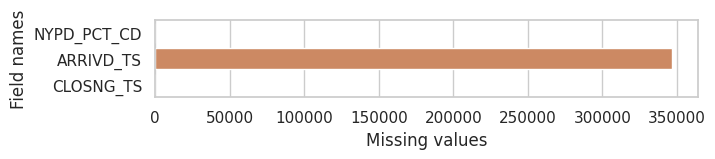

In [3]:
calls = pd.read_csv('/home/airflow/data/NYPD_Calls_for_Service__Year_to_Date_.csv') # CALLS
display(calls.head(1))
print('RECORDS: {:,}'.format(calls.shape[0])); line()
show_uniques_values(calls, 'NYPD_PCT_CD',   4, 13)
show_uniques_values(calls, 'BORO_NM',       4, 13)
show_uniques_values(calls, 'PATRL_BORO_NM', 3, 13)
show_uniques_values(calls, 'RADIO_CODE',    9, 13)
show_uniques_values(calls, 'TYP_DESC',      3, 13)
show_uniques_values(calls, 'CIP_JOBS',      4, 13); 
show_missing_values(calls.isna().sum(),   True, 7, 1)

# <span style='font-family:Verdana;color:red;line-height:40px'>Arrests</span>

As per the `data.gov`, this dataset provides a list of arrests in New York City and it includes detailed information about each arrest made by the NYPD, including the type of crime, location, and time of enforcement. The data is manually extracted and reviewed by the Office of Management Analysis and Planning on a quarterly basis before being published on the NYPD website. Along with the crime-related details, the dataset also includes demographic information about the suspects.

[Data](https://catalog.data.gov/dataset/nypd-arrest-data-year-to-date) |
[Analysis](#Analysis:-Arrests) |
[Facts](#Facts:-Arrest)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,263187871,02/07/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,S,120,0,25-44,M,BLACK,951637,171141,40.636362,-74.117505,POINT (-74.117505 40.636362)


RECORDS: 54,576
________________________________________________________________________________
PD_DESC   : ['(null)', 'A.B.C.,FALSE PROOF OF AGE', 'ACCOSTING,FRAUDULENT'] of (209) values.
OFNS_DESC : ['(null)', 'ADMINISTRATIVE CODE', 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED'] of (61) values.
LAW_CODE  : ['ABC0064B00', 'ABC0065000', 'ABC0065B00', 'ABC0092000', 'ABC0096000'] of (747) values.
AGE_GROUP : [18-24, 25-44, 45-64, 65+, <18] of (5) values.
PERP_SEX  : [F, M, U] of (3) values.
PERP_RACE : ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK'] of (7) values.
________________________________________________________________________________
Missing values

PD_CD         251
KY_CD         251
LAW_CAT_CD    420
________________________________________________________________________________


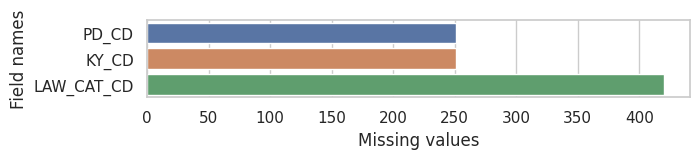

In [4]:
arrests = pd.read_csv('/home/airflow/data/NYPD_Arrest_Data__Year_to_Date_.csv') # ARRESTS
display(arrests.head(1))
print('RECORDS: {:,}'.format(arrests.shape[0])); line()
show_uniques_values(arrests, 'PD_DESC',   3, 9)
show_uniques_values(arrests, 'OFNS_DESC', 3, 9)
show_uniques_values(arrests, 'LAW_CODE',  5, 9)
show_uniques_values(arrests, 'AGE_GROUP', 5, 9)
show_uniques_values(arrests, 'PERP_SEX',  3, 9)
show_uniques_values(arrests, 'PERP_RACE', 3, 9);
show_missing_values(arrests.isna().sum(), True, 7, 1) 

# <span style='font-family:Verdana;color:red;line-height:40px'>Suburbs</span>

This dataset is used to enrich the location/precinct/borowough as has a common data used across the other datasets. This dataset contains the `latitude` and `longitude` where the incident occured and it is intended for the development of the visual presentation of the statistcs on: `shootings`, `calls` and `arrests`.


- `/home/airflow/data/NHoodNameCentroids.csv`

[Data](https://catalog.data.gov/dataset/neighborhood-names-gis) |
[Analysis](#Analysis:-Suburbs)

,the_geom,OBJECTID,Name,Stacked,AnnoLine1,AnnoLine2,AnnoLine3,AnnoAngle,Borough
0,POINT (-73.8472005205491 40.89470517661004),1,Wakefield,1,Wakefield,NaN,NaN,0,Bronx


RECORDS: 292
________________________________________________________________________________
Name      : ['Annadale', 'Arden Heights', 'Arlington', 'Arrochar'] of (295) values.
AnnoLine1 : ['Annadale', 'Arden', 'Arlington', 'Arrochar'] of (256) values.
AnnoLine2 : ['Acres', 'Basin', 'Bay', 'Beach', 'Bridge'] of (76) values.
AnnoLine3 : ['Beach', 'City', 'Gardens', 'Hills', 'Side'] of (6) values.
Borough   : [Bronx, Brooklyn, Manhattan, Queens, Staten Island] of (5) values.
________________________________________________________________________________
Missing values

AnnoLine2    133
AnnoLine3    290
________________________________________________________________________________


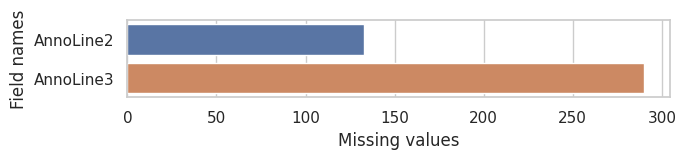

In [5]:
suburbs = pd.read_csv('/home/airflow/data/NHoodNameCentroids.csv') # SUBURBS
display(suburbs.head(1))
print('RECORDS: {:,}'.format(shootings.shape[0])); line()
show_uniques_values(suburbs, 'Name',      4, 9)
show_uniques_values(suburbs, 'AnnoLine1', 4, 9)
show_uniques_values(suburbs, 'AnnoLine2', 5, 9)
show_uniques_values(suburbs, 'AnnoLine3', 5, 9)
show_uniques_values(suburbs, 'Borough',   5, 9)
show_missing_values(suburbs.isna().sum(), True, 7, 1)

# Step 2: Explore and Assess the Data
- Load data into the Staging Area
- Exploring the data, identify data quality issues, like missing values, duplicate data, etc.

>NOTE: <span style='color:red;line-height:40px'>[Airflow in Docker](#Docker) is provided below to build the data pipelines and create and test the data model, run tests.</span>
---
[Top](#Project-Summary) |
[Create Staging Tables](#Create-Staging-Tables) 
[Copy Staging Data](#Copy-Staging-Data) 

## <span style='color:gray;line-height:40px'>Create Staging Tables</span>

In [6]:
execute("""
DROP FUNCTION IF EXISTS ISNULL(anyelement, anyelement);
CREATE OR REPLACE FUNCTION ISNULL(param1 anyelement, param2 anyelement) RETURNS anyelement AS 
$$
BEGIN
    IF param1 IS NULL OR param1::TEXT = '(null)' THEN
        RETURN param2;
    ELSE
        RETURN param1;
    END IF;
END;
$$ 
LANGUAGE plpgsql;
""")

execute("""
DROP TABLE IF EXISTS staging_suburbs;
CREATE TABLE IF NOT EXISTS staging_suburbs (
     "the_geom"  TEXT,
     "OBJECTID"  BIGINT,
     "Name"      TEXT,
     "Stacked"   BIGINT,
     "AnnoLine1" TEXT,
     "AnnoLine2" TEXT,
     "AnnoLine3" TEXT,
     "AnnoAngle" BIGINT,
     "Borough"   TEXT
);

DROP TABLE IF EXISTS staging_shootings;
CREATE TABLE IF NOT EXISTS staging_shootings (
     "INCIDENT_KEY"       BIGINT,
     "OCCUR_DATE"         TEXT,
     "OCCUR_TIME"         TEXT,
     "BORO"               TEXT,
     "LOC_OF_OCCUR_DESC"  TEXT,
     "PRECINCT"           TEXT,
     "JURISDICTION_CODE"  TEXT,
     "LOC_CLASSFCTN_DESC" TEXT,
     "LOCATION_DESC"      TEXT,
     "STATISTICAL_MURDER_FLAG" BOOLEAN,
     "PERP_AGE_GROUP"     TEXT,
     "PERP_SEX"           TEXT,
     "PERP_RACE"          TEXT,
     "VIC_AGE_GROUP"      TEXT,
     "VIC_SEX"            TEXT,
     "VIC_RACE"           TEXT,
     "X_COORD_CD"         TEXT,
     "Y_COORD_CD"         TEXT,
     "Latitude"           TEXT,
     "Longitude"          TEXT,
     "Lon_Lat"            TEXT
);

DROP TABLE IF EXISTS staging_calls;
CREATE TABLE IF NOT EXISTS staging_calls (
     "CAD_EVNT_ID"   BIGINT,
     "CREATE_DATE"   TEXT,
     "INCIDENT_DATE" TEXT,
     "INCIDENT_TIME" TEXT,
     "NYPD_PCT_CD"   TEXT,
     "BORO_NM"       TEXT,
     "PATRL_BORO_NM" TEXT,
     "GEO_CD_X"      BIGINT,
     "GEO_CD_Y"      BIGINT,
     "RADIO_CODE"    TEXT,
     "TYP_DESC"      TEXT,
     "CIP_JOBS"      TEXT,
     "ADD_TS"        TEXT,
     "DISP_TS"       TEXT,
     "ARRIVD_TS"     TEXT,
     "CLOSNG_TS"     TEXT,
     "Latitude"      TEXT,
     "Longitude"     TEXT
);

DROP TABLE IF EXISTS staging_arrests;
CREATE TABLE IF NOT EXISTS staging_arrests (
     "ARREST_KEY"  BIGINT,
     "ARREST_DATE" TEXT,
     "PD_CD"       TEXT,
     "PD_DESC"     TEXT,
     "KY_CD"       TEXT,
     "OFNS_DESC"   TEXT,
     "LAW_CODE"    TEXT,
     "LAW_CAT_CD"  TEXT,
     "ARREST_BORO" TEXT,
     "ARREST_PRECINCT"   BIGINT,
     "JURISDICTION_CODE" BIGINT,
     "AGE_GROUP"   TEXT,
     "PERP_SEX"    TEXT,
     "PERP_RACE"   TEXT,
     "X_COORD_CD"  BIGINT,
     "Y_COORD_CD"  BIGINT,
     "Latitude"    TEXT,
     "Longitude"   TEXT,
     "New Georeferenced Column" TEXT
);
""");
select("select * from pg_tables where tablename like 'stag%%';")

2023-07-10 19:53:00.234: SQL successfully executed: (-1) rows.
2023-07-10 19:53:00.495: SQL successfully executed: (-1) rows.
(4) records in (8) field(s)


,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,airflow,staging_arrests,airflow,None,False,False,False,False
1,airflow,staging_calls,airflow,None,False,False,False,False
2,airflow,staging_shootings,airflow,None,False,False,False,False
3,airflow,staging_suburbs,airflow,None,False,False,False,False


##  <span style='font-family:Verdana;color:gray;line-height:40px'>Copy Staging Data</span>
[Top](#Step-2:-Explore-and-Assess-the-Data) | [Project Summary](#Project-Summary)

In [7]:
execute("""
COPY staging_shootings 
    FROM '/home/airflow/data/NYPD_Shooting_Incident_Data__Year_To_Date_.csv'
    WITH (FORMAT CSV, HEADER True);

COPY staging_calls
    FROM '/home/airflow/data/NYPD_Calls_for_Service__Year_to_Date_.csv'
    WITH (FORMAT CSV, HEADER True);

COPY staging_arrests
    FROM '/home/airflow/data/NYPD_Arrest_Data__Year_to_Date_.csv'
    WITH (FORMAT CSV, HEADER True);

COPY staging_suburbs
    FROM '/home/airflow/data/NHoodNameCentroids.csv'
    WITH (FORMAT CSV, HEADER True);

ALTER TABLE staging_calls DROP COLUMN IF EXISTS point;
ALTER TABLE staging_calls ADD COLUMN point TEXT;
UPDATE staging_calls SET point = CONCAT('POINT(', "Longitude", ' ', "Latitude", ')');
""")

2023-07-10 19:53:18.674: SQL successfully executed: (1,863,800) rows.


## <span style='font-family:Verdana;color:navy;line-height:40px'>Analysis: `staging_shootings`</span>

---
[Top](#Step-2:-Explore-and-Assess-the-Data) | 
[Staging](#Shootings) |
[Facts](#Facts:-Shooting) |
[Project Summary](#Project-Summary)

In [8]:
shootings_duplicates = select("""
SELECT a."INCIDENT_KEY" AS id, COUNT(*) AS duplicates
FROM staging_shootings AS a
GROUP BY a."INCIDENT_KEY"
HAVING COUNT(a.*) > 1
ORDER BY "duplicates" DESC;
""")
    
show_additional_entries(shootings, 'INCIDENT_KEY', shootings_duplicates)
shootings_duplicates.head(4)

(37) records in (2) field(s)
292 records found with 222 unique keys.
37 keys found with 107 records, having 70 extra entries.


,id,duplicates
0,263503175,16
1,263211697,6
2,262334290,4
3,262334289,4


### <span style='font-family:Verdana;color:gray;'>Investigate duplicates</span>
- `263503175` has 16 entries identified in `staging_shootings` table
- [analyse the reasons for the duplicate values](https://data.cityofnewyork.us/api/views/833y-fsy8/files/e4e3d86c-348f-4a16-a17f-19480c089429?download=true&filename=NYPD_Shootings_Incident_Level_Data_Footnotes.pdf) 

In [9]:
print('Two shooters were involved in this incident.')
display(select("""
SELECT 
    DISTINCT
    "INCIDENT_KEY"   AS shooter_id,
    "PERP_AGE_GROUP" AS age,
    "PERP_SEX"       AS sex,
    "PERP_RACE"      AS race
    ---"STATISTICAL_MURDER_FLAG" AS murder
FROM staging_shootings
WHERE "INCIDENT_KEY" IN 
(
    SELECT "INCIDENT_KEY"
    FROM staging_shootings
    GROUP BY "INCIDENT_KEY"
    HAVING COUNT(DISTINCT CONCAT("INCIDENT_KEY", "OCCUR_DATE", "OCCUR_TIME", 
        "BORO", "LOC_OF_OCCUR_DESC", "PRECINCT", "JURISDICTION_CODE", "LOC_CLASSFCTN_DESC", "LOCATION_DESC", 
        "STATISTICAL_MURDER_FLAG", "PERP_AGE_GROUP", "PERP_SEX", "PERP_RACE", "VIC_AGE_GROUP", "VIC_SEX", "VIC_RACE"))>1
)
AND "INCIDENT_KEY" = 263503175
ORDER BY "INCIDENT_KEY";
"""))

print('Four victims identified in the incident.')
display(select("""
SELECT 
    DISTINCT
    "INCIDENT_KEY"  AS victim_id,
    "VIC_AGE_GROUP" AS age,
    "VIC_SEX"       AS sex,
    "VIC_RACE"      AS race
    ---"STATISTICAL_MURDER_FLAG" AS murder
FROM staging_shootings
WHERE "INCIDENT_KEY" IN 
(
    SELECT "INCIDENT_KEY"
    FROM staging_shootings
    GROUP BY "INCIDENT_KEY"
    HAVING COUNT(DISTINCT CONCAT("INCIDENT_KEY", "OCCUR_DATE", "OCCUR_TIME", 
        "BORO", "LOC_OF_OCCUR_DESC", "PRECINCT", "JURISDICTION_CODE", "LOC_CLASSFCTN_DESC", "LOCATION_DESC", 
        "STATISTICAL_MURDER_FLAG", "PERP_AGE_GROUP", "PERP_SEX", "PERP_RACE", "VIC_AGE_GROUP", "VIC_SEX", "VIC_RACE"))>1
)
AND "INCIDENT_KEY" = 263503175
ORDER BY "INCIDENT_KEY";
"""))

Two shooters were involved in this incident.
(2) records in (4) field(s)


,shooter_id,age,sex,race
0,263503175,25-44,M,WHITE HISPANIC
1,263503175,45-64,M,WHITE HISPANIC


Four victims identified in the incident.
(4) records in (4) field(s)


,victim_id,age,sex,race
0,263503175,18-24,M,BLACK
1,263503175,25-44,M,BLACK
2,263503175,25-44,M,WHITE HISPANIC
3,263503175,45-64,M,BLACK


In [10]:
print("Uknown perpetrators.")
select("""
SELECT "INCIDENT_KEY","PERP_AGE_GROUP", "PERP_SEX","PERP_RACE"
FROM staging_shootings
WHERE
    ISNULL("PERP_AGE_GROUP", NULL) IS NULL OR
    ISNULL("PERP_SEX", NULL) IS NULL OR
    ISNULL("PERP_RACE", NULL) IS NULL
""").head(2)

Uknown perpetrators.
(159) records in (4) field(s)


,INCIDENT_KEY,PERP_AGE_GROUP,PERP_SEX,PERP_RACE
0,265674098,(null),(null),(null)
1,261968807,(null),(null),(null)


In [11]:
print("Uknown perpetrators.")
select("""
SELECT "INCIDENT_KEY","Latitude", "Longitude"
FROM staging_shootings
WHERE
    ISNULL("Latitude", NULL) IS NULL OR
    ISNULL("Longitude", NULL) IS NULL 
""").head(2)

Uknown perpetrators.
(11) records in (3) field(s)


,INCIDENT_KEY,Latitude,Longitude
0,264617699,None,None
1,263211697,None,None


<span style='font-family:Verdana;color:Red'>**Findings**</span>:
Expected duplicate keys are identified due to additional demographics records for a multiple perpetrators and victim stored in this dataset. As it can be seen upon examination of the case `263503175`, it evident that ther are 16 records with this key, Furhter research indicate that there were two shooters and four victims.

The open source research of the incident, which occurred on February 10, 2023, at 14:30 near the Popay fast food establishment, was reported to be a quadriple shooting, [involve one fatality and three injuries](https://www.cbsnews.com/newyork/live-updates/one-person-killed-3-wounded-in-bronx-shooting/). [Two shooters were apprehended for the shootings.](https://bronx.com/salvatore-rivera-51-arrested-for-the-murder-of-jeremiah-smith-24/). Legal case was not found to accurately substantiate the details of this shooting incident, but found media articles on incident suggests that there were two shooters. This is coroborated in the previous article. The picture of the shooter is also identified online and published by another [website](https://opoyi.com/usa/who-is-salvatore-rivera-51-year-old-suspect-in-bronx-shooting-taken-into-custody/). While another [story](https://abc7ny.com/nyc-crime-shootings-weekend-brothers-killed-shooting/12809891/) suggest that the two individuals died from the wounds, it remanins inconclusive if this was from the same incident. This remains partially inconclusive as the legal case was not found to cororborate these findings. 

Within the 16 records, there are positvie and negative `STATISTICAL_MURDER_FLAG`. For the above given reasons, the demographic data will be stored in dimension tables. While duplicates are found for the `STATISTICAL_MURDER_FLAG` with both `True` and `False` values it remains inconclusive what is the purpose of this field. For this excercise, this will remain inconclusive and it will be ignored by moving this field in it's own table with a key to preserve actual data. 

Llatitude and longitude values information is also found to be missing for some records. To reduce diminishing the statistical value, missing values will be transformed using the `ISNULL` stored procedure.

### <span style='font-family:Verdana;color:gray;'>Media resources</span>
[ABC NY](https://abc7ny.com/bronx-shooting-suspect-4-shot/12800178/) | 
[Bronx](https://bronx.com/salvatore-rivera-51-arrested-for-the-murder-of-jeremiah-smith-24/) |
[Perpertrator](https://opoyi.com/usa/who-is-salvatore-rivera-51-year-old-suspect-in-bronx-shooting-taken-into-custody/) |
[ABC NY](https://abc7ny.com/nyc-crime-shootings-weekend-brothers-killed-shooting/12809891/)
[S.R. 51yo shooter](https://opoyi.com/usa/who-is-salvatore-rivera-51-year-old-suspect-in-bronx-shooting-taken-into-custody/)


## <span style='font-family:Verdana;color:gray;line-height:40px'>Analysis: `staging_calls`</span>
- check for key constraint violation
---
[Top](#Step-2:-Explore-and-Assess-the-Data) | 
[Calls](#Calls) |
[Facts](#Facts:-Call)

In [12]:
calls_duplicates = select("""
SELECT a."CAD_EVNT_ID" AS id, COUNT(*) AS duplicates
FROM staging_calls AS a --WHERE a."ARRIVD_TS" IS NULL
GROUP BY a."CAD_EVNT_ID"
HAVING COUNT(a.*) > 1
ORDER BY "duplicates" DESC;
""")
show_additional_entries(calls, 'CAD_EVNT_ID', calls_duplicates)
calls_duplicates.head(2)

(55953) records in (2) field(s)
1863800 records found with 1806803 unique keys.
55953 keys found with 112950 records, having 56997 extra entries.


,id,duplicates
0,92615965,4
1,92340238,3


### <span style='font-family:Verdana;color:gray;'>Investigate duplicates</span>
---
[Top](#Step-2:-Explore-and-Assess-the-Data) | 
[Calls](#Calls) |
[Facts](#Facts:-Call)

In [13]:
select("""
SELECT 
    DISTINCT
    "CAD_EVNT_ID" AS key,
    "ADD_TS" AS added, "DISP_TS" AS dispatched, "ARRIVD_TS" AS arrived, "CLOSNG_TS" AS closed
FROM staging_calls
WHERE "CAD_EVNT_ID" IN 
(
    SELECT "CAD_EVNT_ID"
    FROM staging_calls
    GROUP BY "CAD_EVNT_ID"
    HAVING COUNT(DISTINCT CONCAT("CAD_EVNT_ID", "CREATE_DATE", "INCIDENT_DATE", "INCIDENT_TIME",
    "NYPD_PCT_CD", "BORO_NM", "PATRL_BORO_NM", "GEO_CD_X", "GEO_CD_Y", "RADIO_CODE", "TYP_DESC", 
    "CIP_JOBS", "ADD_TS", "DISP_TS", "ARRIVD_TS", "CLOSNG_TS", "point")) > 1
)
AND "CAD_EVNT_ID" IN (92615965)
ORDER BY "CAD_EVNT_ID";
""")

(4) records in (5) field(s)


,key,added,dispatched,arrived,closed
0,92615965,02/24/2023 08:12:48 PM,02/24/2023 08:13:21 PM,02/24/2023 08:27:49 PM,02/24/2023 09:31:53 PM
1,92615965,02/24/2023 08:12:48 PM,02/24/2023 08:15:47 PM,02/24/2023 08:15:49 PM,02/24/2023 11:30:52 PM
2,92615965,02/24/2023 08:12:48 PM,02/24/2023 09:17:31 PM,None,02/25/2023 12:21:34 AM
3,92615965,02/24/2023 08:13:20 PM,02/24/2023 08:24:00 PM,None,02/24/2023 09:29:56 PM


<span style='font-family:Verdana;color:red;font-weight:bold'>**Finding**</span>: One `NYPD_PCT_CD` value is found empty. This will be addressed using the `ISNULL` procedure to resolve this issue. Additionally, there are 13 missing values for `CLOSING_TS` and 346,676 missing values for `ARRIVD_TS`. As part of this project, the fields `ADD_TS`, `DISP_TS`, `ARRIVD_TS` and `CLOSNG_TS` will be transferred to the dimension table as the primary focus stays on a locations. This aims to reduce the number of necessary duplicates in the facts table, simplifying the facts table and also improve the processing speed. Having this data in the dimension table will ensure that the data is preserved and when needed it can be accessed without losing it.

## <span style='font-family:Verdana;color:gray;'>Analysis: `Arrests`</span>
- check for key violation
---
[Top](#Step-2:-Explore-and-Assess-the-Data) | 
[Arrests](#Arrests) |
[Facts](#Facts-Arrest)

In [14]:
arrest_duplicates = select("""
SELECT
    a."ARREST_KEY" AS key,
    COUNT(*) AS duplicates
FROM staging_arrests AS a
--WHERE a."ARREST_KEY" IS NULL
GROUP BY a."ARREST_KEY"
HAVING COUNT(a.*) > 1
ORDER BY "duplicates" DESC
;
""")
show_additional_entries(arrests, 'ARREST_KEY', arrest_duplicates)
if arrest_duplicates.shape[0] > 0:
    print(f"Duplicates\n{'-'*30}")
    arrest_duplicates.head(3)

(0) records in (2) field(s)
54576 records found with 54576 unique keys.
0 keys found with 0 records, having 0 extra entries.


<span style='font-family:Verdana;color:red;font-weight:bold'>Findings: </span>This data set has no duplicates, fields `PD_CD` and `KY_CD` have **251** missing values and `LAW_CAT_CD` is missing **420** values. All missing text values will be labeled as unknown (**UNKN**).

## <span style='font-family:Verdana;color:gray;line-height:40px'>Approach to data quality</span>
Due to the inherent nature of this statistical data, it is expected to have missing values in certain cases where data could not be obtained due to a circumstances of the event or a collection failure. To maintain the integrity of the information, a simple PostgreSQL `stored procedure` (code provided below) will be utilized to *transform* the data where needed. This ensures that missing values will be categorised as "unknown," maintaining valid factual information, but not having a null values is aim. It is important to retain unknown values as they can easily be filtered out, but once removed, they cannot be recovered.

For example, in cases of shootings, the demographics of the perpetrators may be unknown. As observed in the given examples, there are 16 individual records associated with the same key, whereas in reality, there may only be 6 records representing two shooters and 4 victims. It is also likely that victim information will be present in the dataset, and those fields will be created as `NOT NULL` fields to ensure their availability. Although the focus of this exercise is to utilize geolocation data for a visual presentation dashboard, similar to ComStat dashboards, the ultimate goal remains to preserve the accuracy of the actual data.

```sql
DROP FUNCTION IF EXISTS ISNULL(anyelement, anyelement);
CREATE OR REPLACE FUNCTION ISNULL(param1 anyelement, param2 anyelement) RETURNS anyelement AS 
$$
BEGIN
    IF param1 IS NULL OR param1::TEXT = '(null)' THEN
        RETURN param2;
    ELSE
        RETURN param1;
    END IF;
END;
$$ 
LANGUAGE plpgsql;
```

# <span style='font-family:Verdana;color:gray;line-height:40px'>Step 3: Define the Data Model</span>
---
[Project Summary](#Project-Summary)

While the primary goal of data model is to be simple to use for dashboards. Preparation is also considered for the purpose of the machine learning algorithms to optimize the data for improved performance machine learning models. One of the main tasks is transforming textual data into numerical values. While it is possible to  apply  techniques such as Bag of Words, Word Embeddings, and TF-IDF, for the data engineering pipeline most of the data will be prepared. These techniques can be applied for those fields that are left in text format and that contain small number of textual values.

Preprocessing steps will also be considered such as data cleaning, handling missing values, categorical encoding, and scaling. Further guidelines include selecting appropriate transformation methods, experimenting with different techniques, evaluating model performance, and iterating to improve data quality and model results. In a real life setting, the aproach would be to  consult literature and experts for achieving optimal outcomes.

## <span style='font-family:Verdana;color:gray;line-height:40px'>3.1 Conceptual Data Model</span>
<span style='color:gray;'>Map out the conceptual data model and explain why you chose that model
As explained in the introduction, the purpose of the old model is to transform all textual data into numerical representations, achieved through dimensionality and the use of keys instead of text. Of course, this needs to be optimized for performance.</span>

Data with a textual entries will been moved to dimension tables. Given the quantity and nature of the data, which is not of a heavy data stream large in volume and as it pertains to statistical data, the model will be adjusted for visual dashboards and presentation of locations in a map for this specific scenario. However, should there be a need for a different purpose the data is easily accessible via dimension tables.

The following is the conceptual representation of the data model:

- [**Staging tables**](#Create-Staging-Tables)
- [**dimensions**](#Dimension-Tables)
- [**facts**](#Create-Fact-Tables)

# <span style='font-family:Verdana;color:navy;line-height:40px'>Step 4: Run Pipelines to Model the Data</span>
---
[Top](#Project-Summary) | 
[Shooting Location](#Dimension:-Shooting-Location) |
[Offender & Victim](#Dimension:-Offender) |
[Call Times](#Dimension:-Call-Times) |
[Call Code](#Dimension:-Call-Code) |
[Precinct Patrol](#Dimension:-Precinct-Patrol) |
[Arrest Legal](#Dimension:-Arrest-Legal) |
[Precinct](#Dimension:-Precinct) |
[Location](#Dimension:-Location) |
[Facts](#Facts:-Shooting)

## <span style='color:gray'>Dimension Tables</span>

### <span style='color:gray'>Dimension: Shooting Location</span>
[Top](#Project-Summary) |
[Dimension Tables](#Dimension-Tables) |
[Analysis](#Analysis:-staging_shootings) | 
[Facts](#Facts:-Shooting)

In [15]:
execute("""
DROP TABLE IF EXISTS dim_shooting_location;
CREATE TABLE IF NOT EXISTS dim_shooting_location(
    id SERIAL PRIMARY KEY,
    site TEXT NOT NULL,
    class TEXT NOT NULL,
    description TEXT NOT NULL
);
ALTER TABLE dim_shooting_location ADD CONSTRAINT dim_shooting_location_unique UNIQUE (site, class, description);
""")
execute("""
TRUNCATE TABLE dim_shooting_location;
INSERT INTO dim_shooting_location(site, class, description)
SELECT
    DISTINCT ON(site, class, description)
    site, class, description
FROM (
    SELECT
        ISNULL("LOC_OF_OCCUR_DESC", 'UKNWON') AS site,
        ISNULL("LOC_CLASSFCTN_DESC", 'UNKWN') AS class, 
        ISNULL("LOCATION_DESC", 'UNKWN') AS description
    FROM staging_shootings
) AS r
ORDER BY site, class, description;
""")

df = select("select * from dim_shooting_location ;")
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'site',        7, 11)
show_uniques_values(df, 'class',       3, 11)
show_uniques_values(df, 'description', 3, 11)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(1))

2023-07-10 19:53:37.690: SQL successfully executed: (-1) rows.
2023-07-10 19:53:37.728: SQL successfully executed: (34) rows.
(34) records in (4) field(s)
RECORDS: 34
________________________________________________________________________________
site        : [INSIDE, OUTSIDE] of (2) values.
class       : ['COMMERCIAL', 'DWELLING', 'HOUSING'] of (8) values.
description : ['BAR/NIGHT CLUB', 'COMMERCIAL BLDG', 'FAST FOOD'] of (15) values.
There are no missing values found.
________________________________________________________________________________


,id,site,class,description
33,34,OUTSIDE,VEHICLE,UNKWN


### <span style='color:gray'>Dimension: Shooting Murder Flag</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) |
[Dimension Tables](#Dimension-Tables) |
[Analysis](#Analysis:-staging_shootings) | 
[Facts](#Facts:-Shooting)

In [16]:
execute("""
DROP TABLE IF EXISTS dim_shooting_murder_flag;
CREATE TABLE IF NOT EXISTS dim_shooting_murder_flag(
    id SERIAL PRIMARY KEY,
    key BIGINT NOT NULL,
    flag BOOLEAN NOT NULL
);
ALTER TABLE dim_shooting_murder_flag ADD CONSTRAINT dim_shooting_murder_flag_unique UNIQUE (key, flag);
""")
execute("""
TRUNCATE TABLE dim_shooting_murder_flag;
INSERT INTO dim_shooting_murder_flag(key, flag)
SELECT
    DISTINCT ON(key, flag)
    key, flag
FROM (
    SELECT
        "INCIDENT_KEY" AS key,
        ISNULL("STATISTICAL_MURDER_FLAG"::BOOLEAN, False) AS flag
    FROM staging_shootings
) AS r
ORDER BY key
;
""")

df = select("select * from dim_shooting_murder_flag ;")
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'flag',        7, 11)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(1))

2023-07-10 19:53:39.546: SQL successfully executed: (-1) rows.
2023-07-10 19:53:39.582: SQL successfully executed: (233) rows.
(233) records in (3) field(s)
RECORDS: 233
________________________________________________________________________________
flag        : [False, True] of (2) values.
There are no missing values found.
________________________________________________________________________________


,id,key,flag
232,233,266069023,True


### <span style='color:gray'>Dimension: Offender</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) |
[Dimension Tables](#Dimension-Tables) |
[Arrests](#Arrests) | 
[Shootings](#Shootings) | 
[Analysis](#Analysis:-staging_shootings) | 
[Facts](#Facts:-Shooting)

In [17]:
execute("""
DROP TABLE IF EXISTS dim_offender;
CREATE TABLE IF NOT EXISTS dim_offender(
    id SERIAL PRIMARY KEY,
    key BIGINT NOT NULL,
    age TEXT NOT NULL,
    sex TEXT NOT NULL,
    race TEXT NOT NULL,
    source TEXT NOT NULL
);
ALTER TABLE dim_offender ADD CONSTRAINT dim_offender_unique UNIQUE (key, age, sex, race, source);
""")

execute("""
TRUNCATE TABLE dim_offender;
INSERT INTO dim_offender(key, age, sex, race, source)
SELECT
    DISTINCT ON(key, age, sex, race)
    key, age, sex, race, source
FROM (
    SELECT
        "INCIDENT_KEY"                    AS key,
        ISNULL("PERP_AGE_GROUP", 'UNKWN') AS age, 
        ISNULL("PERP_SEX",           'U') AS sex, 
        ISNULL("PERP_RACE",      'UNKWN') AS race,
        'staging_shootings'               AS source
    FROM staging_shootings
) AS r
ORDER BY key, age, sex, race
;
""")

execute("""
INSERT INTO dim_offender(key, age, sex, race, source)
SELECT
    DISTINCT ON(key, age, sex, race)
    key, age, sex, race, source
FROM (
    SELECT
        "ARREST_KEY"                 AS key,
        ISNULL("AGE_GROUP", 'UNKWN') AS age,
        ISNULL("PERP_SEX",      'U') AS sex,
        ISNULL("PERP_RACE", 'UNKWN') AS race,
        'staging_arrests'            AS source
    FROM staging_arrests
) AS r
WHERE
    CONCAT(age, sex, race, source) NOT IN (SELECT CONCAT(age, sex, race, source) FROM dim_offender)
;
""")

execute("""
DROP TABLE IF EXISTS dim_victim;
CREATE TABLE IF NOT EXISTS dim_victim(
    id SERIAL PRIMARY KEY,
    key BIGINT NOT NULL,
    age TEXT NOT NULL,
    sex TEXT NOT NULL,
    race TEXT NOT NULL
);
ALTER TABLE dim_victim ADD CONSTRAINT dim_victim_unique UNIQUE (key, age, sex, race);
""")
execute("""
INSERT INTO dim_victim(key, age, sex, race)
SELECT
    DISTINCT ON(key, age, sex, race)
    key, age, sex, race
FROM (
    SELECT
        "INCIDENT_KEY"                     AS key,
        ISNULL(a."VIC_AGE_GROUP", 'UNKWN') AS age, 
        ISNULL(a."VIC_SEX",           'U') AS sex, 
        ISNULL(a."VIC_RACE",      'UNKWN') AS race
    FROM staging_shootings AS a
) AS r
;
""")

df = select("select * from dim_offender ;")
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'age',   7, 5)
show_uniques_values(df, 'sex',   3, 5)
show_uniques_values(df, 'race',  3, 5)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(1))

2023-07-10 19:53:41.121: SQL successfully executed: (-1) rows.
2023-07-10 19:53:41.159: SQL successfully executed: (234) rows.
2023-07-10 19:53:41.768: SQL successfully executed: (54,576) rows.
2023-07-10 19:53:41.812: SQL successfully executed: (-1) rows.
2023-07-10 19:53:41.835: SQL successfully executed: (251) rows.
(54810) records in (6) field(s)
RECORDS: 54,810
________________________________________________________________________________
age   : [1028, 18-24, 25-44, 45-64, 65+, <18, UNKWN] of (7) values.
sex   : [F, M, U] of (3) values.
race  : ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK'] of (8) values.
There are no missing values found.
________________________________________________________________________________


,id,key,age,sex,race,source
54809,54810,266004089,18-24,U,BLACK,staging_arrests


### <span style='color:gray'>Dimension: Call Times</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) |
[Calls](#Calls) |
[Analysis](#Analysis:-staging_calls) | 
[Facts](#Facts:-Call)

2023-07-10 19:53:43.520: SQL successfully executed: (-1) rows.
2023-07-10 19:53:58.601: SQL successfully executed: (1,863,800) rows.
(1863800) records in (6) field(s)
RECORDS: 1,863,800
________________________________________________________________________________
Missing values

arrived    346676
closed         13
________________________________________________________________________________


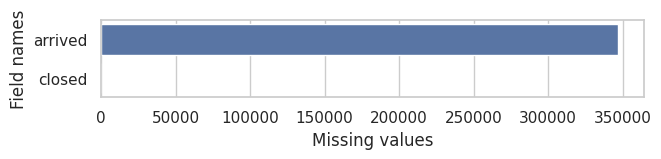

,id,key,added,dispatched,arrived,closed
0,1,91250176,2023-01-01 01:08:21,2023-01-01 01:09:57,NaT,2023-01-01 01:57:44


In [18]:
execute("""
DROP TABLE IF EXISTS dim_call_times;
CREATE TABLE IF NOT EXISTS dim_call_times(
    id SERIAL PRIMARY KEY,
    key BIGINT NOT NULL,
    added TIMESTAMP, 
    dispatched TIMESTAMP, 
    arrived TIMESTAMP,
    closed TIMESTAMP
);
ALTER TABLE dim_call_times ADD CONSTRAINT dim_call_times_unique UNIQUE (key, added, dispatched, arrived, closed);
""")

execute("""
INSERT INTO dim_call_times(key, added, dispatched, arrived, closed)
SELECT
    DISTINCT ON (key, added, dispatched, arrived, closed)
    key, added, dispatched, arrived, closed
FROM
(
    SELECT
        "CAD_EVNT_ID"          AS key,
        "ADD_TS"::TIMESTAMP    AS added, 
        "DISP_TS"::TIMESTAMP   AS dispatched, 
        "ARRIVD_TS"::TIMESTAMP AS arrived, 
        "CLOSNG_TS"::TIMESTAMP AS closed
    FROM staging_calls
) AS r
ORDER BY key, added
;
""")
df = select('select * from dim_call_times;')
print('RECORDS: {:,}'.format(df.shape[0]));
show_missing_values(df.isna().sum(), True, 7, 1)
display(df.head(1))

### <span style='color:gray'>Dimension: Call Code</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) |
[Dimension Tables](#Dimension-Tables) |
[Calls](#Calls) |
[Facts](#Facts:-Call)

In [19]:
execute("""
DROP TABLE IF EXISTS dim_call_code;
CREATE TABLE IF NOT EXISTS dim_call_code (
    id         SERIAL PRIMARY KEY,
    code        TEXT NOT NULL,
    description TEXT NOT NULL,
    category    TEXT NOT NULL
);
ALTER TABLE dim_call_code ADD CONSTRAINT dim_call_code_unique UNIQUE (code);
""")

execute("""
INSERT INTO dim_call_code(code, description, category)
SELECT DISTINCT ON (code)
    ISNULL("RADIO_CODE", 'UNKWN') AS code,
    ISNULL("TYP_DESC",   'UNKWN') AS description,
    ISNULL("CIP_JOBS",   'UNKWN') AS category
FROM staging_calls;
""")

df = select('select * from dim_call_code;')
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'code',        9, 11)
show_uniques_values(df, 'description', 3, 11)
show_uniques_values(df, 'category',    7, 11)
show_missing_values(df.isna().sum(), True,   7, 1);line();
display(df.head(1))

2023-07-10 19:54:16.810: SQL successfully executed: (-1) rows.
2023-07-10 19:54:25.490: SQL successfully executed: (464) rows.
(464) records in (4) field(s)
RECORDS: 464
________________________________________________________________________________
code        : ['001', '002', '004', '006', '008', '012', '10F1', '10F2', '10F5'] of (464) values.
description : ['10-53 NO RMP REQUIRED', '311 REFERRAL', 'ALARMS: AUDIBLE/INSIDE'] of (461) values.
category    : [Critical, Non CIP, Non Critical, Serious] of (4) values.
There are no missing values found.
________________________________________________________________________________


,id,code,description,category
0,1,001,HANG UP,Non CIP


### <span style='color:gray'>Dimension: Precinct Patrol</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) |
[Project Summary](#Project-Summary) | 
[Dimension Tables](#Dimension-Tables) |
[Calls](#Calls) |
[Facts](#Facts:-Call)

In [20]:
execute("""
DROP TABLE IF EXISTS dim_precinct_patrol;
CREATE TABLE IF NOT EXISTS dim_precinct_patrol (
    id    SERIAL PRIMARY KEY,
    patrol TEXT NOT NULL
);
ALTER TABLE dim_precinct_patrol ADD CONSTRAINT dim_precinct_patrol_unique UNIQUE (patrol);
""")

execute("""
TRUNCATE TABLE dim_precinct_patrol;
INSERT INTO dim_precinct_patrol(patrol)
SELECT DISTINCT ON(a."PATRL_BORO_NM") ISNULL(a."PATRL_BORO_NM", 'UNKWN') AS patrol 
FROM staging_calls AS a ORDER BY a."PATRL_BORO_NM";
""")

df = select('select * from dim_precinct_patrol;')
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'patrol',  3, 7)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(1))

2023-07-10 19:54:25.598: SQL successfully executed: (-1) rows.
2023-07-10 19:54:28.288: SQL successfully executed: (9) rows.
(9) records in (2) field(s)
RECORDS: 9
________________________________________________________________________________
patrol  : ['PATROL BORO BKLYN NORTH', 'PATROL BORO BKLYN SOUTH', 'PATROL BORO BRONX'] of (9) values.
There are no missing values found.
________________________________________________________________________________


,id,patrol
8,9,PATROL BORO STATEN ISLAND


### <span style='color:gray'>Dimension: Arrest Legal</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) |
[Project Summary](#Project-Summary) |
[Dimension Tables](#Dimension-Tables) |
[Arrests](#Arrests) |
[Staging](#Analysis:-staging_arrests) |
[Facts](#Facts:-Arrest)

In [21]:
execute("""
DROP TABLE IF EXISTS dim_arrest_legal;
CREATE TABLE IF NOT EXISTS dim_arrest_legal (
    id          SERIAL PRIMARY KEY,
    description TEXT NOT NULL,
    offence     TEXT NOT NULL,
    code        TEXT NOT NULL,
    category    TEXT NOT NULL
);
ALTER TABLE dim_arrest_legal ADD CONSTRAINT dim_arrest_legal_unique UNIQUE (description,offence,code,category);
""")

execute("""
INSERT INTO dim_arrest_legal (description,offence,code,category)
SELECT DISTINCT ON (description,offence,code,category) description, offence, code, category FROM (
SELECT
    ISNULL("PD_DESC",   'UNKWN') AS description,
    ISNULL("OFNS_DESC", 'UNKWN') AS offence,
    ISNULL("LAW_CODE",  'UNKWN') AS code,
    ISNULL("LAW_CAT_CD",'UNKWN') AS category
FROM staging_arrests
) AS r
;
""")

df = select('select * from dim_arrest_legal;')
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'description', 3, 11)
show_uniques_values(df, 'offence',     2, 11)
show_uniques_values(df, 'code',        5, 11)
show_uniques_values(df, 'category',    6, 11)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(1))

2023-07-10 19:54:28.387: SQL successfully executed: (-1) rows.
2023-07-10 19:54:29.166: SQL successfully executed: (747) rows.
(747) records in (5) field(s)
RECORDS: 747
________________________________________________________________________________
description : ['A.B.C.,FALSE PROOF OF AGE', 'ACCOSTING,FRAUDULENT', 'ADM.CODE,UNCLASSIFIED MISDEMEA'] of (209) values.
offence     : ['ADMINISTRATIVE CODE', 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED'] of (61) values.
code        : ['ABC0064B00', 'ABC0065000', 'ABC0065B00', 'ABC0092000', 'ABC0096000'] of (747) values.
category    : [9, F, I, M, UNKWN, V] of (6) values.
There are no missing values found.
________________________________________________________________________________


,id,description,offence,code,category
746,747,"WEAPONS,MFR,TRANSPORT,ETC.",DANGEROUS WEAPONS,PL 2651002,M


### <span style='color:gray'>Dimension: Precinct</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) | 
[Project Summary](#Project-Summary) |
[Dimension Tables](#Dimension-Tables) |
[Suburbs](#Suburbs) |
[Facts](#Facts:-Shooting)

In [22]:
execute("""
DROP TABLE IF EXISTS dim_precinct;
CREATE TABLE IF NOT EXISTS dim_precinct (
    id        SERIAL PRIMARY KEY,
    place     TEXT NOT NULL,
    borough   TEXT NOT NULL,
    point     TEXT NOT NULL
);
ALTER TABLE dim_precinct ADD CONSTRAINT dim_precinct_unique UNIQUE (place, borough, point);
""")

execute("""
TRUNCATE TABLE dim_precinct;
INSERT INTO dim_precinct
SELECT 
    DISTINCT
    "OBJECTID"::INTEGER               AS key, 
    UPPER(ISNULL("Name",    'UNKWN')) AS place, 
    UPPER(ISNULL("Borough", 'UNKWN')) AS borough,
    "the_geom"::TEXT                  AS point
FROM staging_suburbs AS a;
""")
df = select('select * from dim_precinct;')
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'place',   4, 7)
show_uniques_values(df, 'borough', 5, 7)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(1))

2023-07-10 19:54:29.278: SQL successfully executed: (-1) rows.
2023-07-10 19:54:29.314: SQL successfully executed: (299) rows.
(299) records in (4) field(s)
RECORDS: 299
________________________________________________________________________________
place   : ['ANNADALE', 'ARDEN HEIGHTS', 'ARLINGTON', 'ARROCHAR'] of (295) values.
borough : [BRONX, BROOKLYN, MANHATTAN, QUEENS, STATEN ISLAND] of (5) values.
There are no missing values found.
________________________________________________________________________________


,id,place,borough,point
298,299,MADISON,BROOKLYN,POINT (-73.948415153289 40.609377701137696)


### <span style='color:gray'>Dimension: Location</span>
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) | 
[Project Summary](#Project-Summary) | 
[Dimension Tables](#Dimension-Tables) |
[Analysis](#Step-2:-Explore-and-Assess-the-Data) | 
[Facts](#Facts:-Shooting)

In [23]:
execute("""
DROP TABLE IF EXISTS dim_location;
CREATE TABLE IF NOT EXISTS dim_location(
    id SERIAL PRIMARY KEY,
    borough TEXT NOT NULL,
    x_coord INTEGER NOT NULL,
    y_coord INTEGER NOT NULL,
    point TEXT NOT NULL
);
ALTER TABLE dim_location ADD CONSTRAINT dim_location_unique UNIQUE (borough, x_coord, y_coord);
""")

execute("""
INSERT INTO dim_location(borough, x_coord, y_coord, point)
SELECT
    DISTINCT ON(borough, x_coord, y_coord)
    borough, x_coord, y_coord, point
FROM (
    SELECT
        ISNULL("BORO", 'UNKWN') AS borough, 
        "X_COORD_CD"::INTEGER AS x_coord, 
        "Y_COORD_CD"::INTEGER AS y_coord,
        CASE 
            WHEN ISNULL("Latitude", NULL) IS NULL THEN ''
            ELSE CONCAT('POINT (',"Longitude",' ', "Latitude" ,')')
        END AS point
    FROM staging_shootings
) AS r
ORDER BY borough, x_coord, y_coord;
""")

execute("""
INSERT INTO dim_location(borough, x_coord, y_coord, point)
SELECT
    DISTINCT ON(borough, x_coord, y_coord)
    borough, x_coord, y_coord, point
FROM (
    SELECT
        ISNULL("ARREST_BORO", 'UNKWN') AS borough,
        "X_COORD_CD"::INTEGER AS x_coord,
        "Y_COORD_CD"::INTEGER AS y_coord,
        ISNULL("New Georeferenced Column", 'UNKWN') AS point
    FROM staging_arrests
) AS r
WHERE
    CONCAT(borough, x_coord, y_coord) NOT IN (SELECT CONCAT(borough, x_coord, y_coord) FROM dim_location)
ORDER BY borough, x_coord, y_coord;
""")

execute("""
INSERT INTO dim_location(borough, x_coord, y_coord, point)
SELECT
    DISTINCT ON(borough, x_coord, y_coord)
    borough, x_coord, y_coord, point
FROM (
    SELECT
        ISNULL("BORO_NM", 'UNKWN') AS borough,
        "GEO_CD_X"::INTEGER AS x_coord,
        "GEO_CD_Y"::INTEGER AS y_coord,
        CASE 
            WHEN ISNULL("Latitude", NULL) IS NULL THEN ''
            ELSE CONCAT('POINT (',"Longitude",' ', "Latitude" ,')')
        END AS point
    FROM staging_calls
) AS r
WHERE
    CONCAT(borough, x_coord, y_coord) NOT IN (SELECT CONCAT(borough, x_coord, y_coord) FROM dim_location)
ORDER BY borough, x_coord, y_coord;
""")

df = select('select * from dim_location;')
print('RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'borough', 6, 7)
show_uniques_values(df, 'point',   2, 7)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(1))

2023-07-10 19:54:29.442: SQL successfully executed: (-1) rows.
2023-07-10 19:54:29.462: SQL successfully executed: (217) rows.
2023-07-10 19:54:29.856: SQL successfully executed: (16,489) rows.
2023-07-10 19:54:41.62: SQL successfully executed: (74,251) rows.
(90957) records in (5) field(s)
RECORDS: 90,957
________________________________________________________________________________
borough : ['B', 'BRONX', 'BROOKLYN', 'K', 'M', 'MANHATTAN'] of (11) values.
point   : ['', 'POINT (-73.700316 40.739224)'] of (90761) values.
There are no missing values found.
________________________________________________________________________________


,id,borough,x_coord,y_coord,point
90956,90957,UNKWN,1066920,212925,POINT (-73.701628 40.750728)


# <span style='font-family:Verdana;color:red;line-height:40px'>Facts: Shooting</span>
---
Completeness | Accuracy | Uniqueness | Consistency | Relevance | Integrity | Reliability

---
[Top](#Project-Summary) | 
[Analysis](#Analysis:-staging_shootings) |
[Shooting Location](#Dimension:-Shooting-Location) |
[Offender & Victim](#Dimension:-Offender) |
[Shooting Murder Flag](#Dimension:-Shooting-Murder-Flag)|
[Quality Check](#Quality-Check:-Shootings)

In [24]:
execute("""
DROP TABLE IF EXISTS facts_shooting;
CREATE TABLE IF NOT EXISTS facts_shooting (
    key BIGINT PRIMARY KEY,             ---"INCIDENT_KEY"       BIGINT,
    occured TIMESTAMP NOT NULL,         ---"OCCUR_DATE"         TEXT,
                                        ---"OCCUR_TIME"         TEXT,
                                        ---"LOC_OF_OCCUR_DESC"  TEXT,
    precinct_key INTEGER NOT NULL,      ---"PRECINCT"           TEXT,
    site_id INTEGER NOT NULL,
    --- LOCATION                        ---"BORO"               TEXT,
                                        ---"LOC_CLASSFCTN_DESC" TEXT,
                                        ---"LOCATION_DESC"      TEXT,
    location_key BIGINT NOT NULL,       ---"X_COORD_CD"         TEXT,
                                        ---"Y_COORD_CD"         TEXT,
                                        ---"Latitude"           TEXT,
                                        ---"Longitude"          TEXT,
                                        ---"Lon_Lat"            TEXT
    jurisdiction_code INTEGER NOT NULL, ---"JURISDICTION_CODE"  TEXT,
    murder_flag BOOLEAN NOT NULL        ---"S2TATISTICAL_MURDER_FLAG" ,
  --perpetrator_key BIGINT NOT NULL,    ---"PERP_AGE_GROUP"     TEXT,
                                        ---"PERP_SEX"           TEXT,
                                        ---"PERP_RACE"          TEXT,
  --victim_key BIGINT NOT NULL          ---"VIC_AGE_GROUP"      TEXT,
                                        ---"VIC_SEX"            TEXT,
                                        ---"VIC_RACE"           TEXT
);
""");

execute("""
INSERT INTO facts_shooting(key, occured, precinct_key, location_key, site_id, jurisdiction_code, murder_flag)
SELECT
    DISTINCT ON(key)
    key, occured, precinct_key, l.id AS location_key, s.id AS site_id, jurisdiction_code, murder_flag
FROM
(

    SELECT
        "INCIDENT_KEY"                        AS key,
        TO_TIMESTAMP(CONCAT(
            "OCCUR_DATE"::TEXT, ' ',
            "OCCUR_TIME"::TEXT), 
            'MM/DD/YYYY HH24:MI:SS')          AS occured,
        ISNULL("LOC_OF_OCCUR_DESC", 'UNKWN')  AS location_site,
        ISNULL("PRECINCT"::INTEGER, -1)       AS precinct_key,
        ISNULL("BORO", 'UNKWN')               AS borough,
        ISNULL("LOC_CLASSFCTN_DESC", 'UNKWN') AS location_class,
        ISNULL("LOCATION_DESC", 'UNKWN')      AS location_descr,
        "X_COORD_CD"::INTEGER                 AS x_coord,
        "Y_COORD_CD"::INTEGER                 AS y_coord,
      --"Latitude"                            AS latitude,
      --"Longitude"                           AS longitude,
        ISNULL("Lon_Lat", 'UNKWN')            AS point,
        "JURISDICTION_CODE"::INTEGER          AS jurisdiction_code,
        "STATISTICAL_MURDER_FLAG"::BOOLEAN    AS murder_flag,
        ISNULL("PERP_AGE_GROUP", 'UNKWN')     AS perp_age,
        ISNULL("PERP_SEX", 'UNKWN')           AS perp_sex,
        ISNULL("PERP_RACE", 'UNKWN')          AS perp_race,
        ISNULL("VIC_AGE_GROUP", 'UNKWN')      AS vic_age,
        ISNULL("VIC_SEX", 'UNKWN')            AS vic_sex,
        ISNULL("VIC_RACE", 'UNKWN')           AS vic_race
    FROM staging_shootings 
) AS r
LEFT JOIN dim_location AS l ON 
    l."borough" = r."borough" AND
    l."x_coord" = r."x_coord" AND
    l."y_coord" = r."y_coord"   
LEFT JOIN dim_shooting_location AS s ON
    s.site  = r."location_site" AND
    s.class = r."location_class" AND
    s.description = r."location_descr"
ORDER BY key
;
""")

display(select("select * from facts_shooting;").head(2))
df = select("""
SELECT a.*, s.*, 
    o.age AS offender_age, o.sex AS offender_sex, m.flag AS murder_flag, o.race AS offender_race,
    v.age AS victim_age, v.sex AS victim_sex, v.race AS victim_race
FROM facts_shooting a
    LEFT JOIN dim_location AS l ON l.id = a.location_key
    LEFT JOIN dim_shooting_location AS s ON s.id = a.site_id
    LEFT JOIN dim_offender AS o ON o.key = a.key AND o.source = 'staging_shootings'
    LEFT JOIN dim_victim   AS v ON v.key = a.key
    LEFT JOIN dim_shooting_murder_flag AS m ON m.key = a.key
ORDER BY a.key
;
""")
print('FILE RECORDS: {:,}'.format(shootings.shape[0])); 
print('DB RECORDS:   {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'site',          4, 14)
show_uniques_values(df, 'class',         4, 14)
show_uniques_values(df, 'description',   4, 14)
show_uniques_values(df, 'offender_age',  4, 14)
show_uniques_values(df, 'offender_sex',  4, 14)
show_uniques_values(df, 'offender_race', 4, 14)
show_uniques_values(df, 'victim_age',    4, 14)
show_uniques_values(df, 'victim_sex',    4, 14)
show_uniques_values(df, 'victim_race',   4, 14)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(2))


2023-07-10 19:54:41.513: SQL successfully executed: (-1) rows.
2023-07-10 19:54:41.548: SQL successfully executed: (222) rows.
(222) records in (7) field(s)


,key,occured,precinct_key,site_id,location_key,jurisdiction_code,murder_flag
0,261194183,2023-01-01 05:55:00,47,30,51,0,False
1,261204520,2023-01-01 06:47:00,40,33,2,0,False


(292) records in (18) field(s)
FILE RECORDS: 292
DB RECORDS:   292
________________________________________________________________________________
site           : [INSIDE, OUTSIDE] of (2) values.
class          : ['COMMERCIAL', 'DWELLING', 'HOUSING', 'OTHER'] of (8) values.
description    : ['BAR/NIGHT CLUB', 'COMMERCIAL BLDG', 'FAST FOOD', 'GAS STATION'] of (15) values.
offender_age   : ['1028', '18-24', '25-44', '45-64'] of (6) values.
offender_sex   : [F, M, U] of (3) values.
offender_race  : ['ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'UNKWN'] of (6) values.
victim_age     : ['18-24', '25-44', '45-64', '65+'] of (5) values.
victim_sex     : [F, M] of (2) values.
victim_race    : ['ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'WHITE'] of (5) values.
There are no missing values found.
________________________________________________________________________________


,key,occured,precinct_key,site_id,location_key,jurisdiction_code,murder_flag,id,site,class,description,offender_age,offender_sex,murder_flag,offender_race,victim_age,victim_sex,victim_race
290,266049108,2023-03-31 03:45:00,42,33,7,0,False,33,OUTSIDE,STREET,UNKWN,UNKWN,U,False,UNKWN,25-44,M,BLACK HISPANIC
291,266069023,2023-03-31 22:25:00,114,33,183,0,True,33,OUTSIDE,STREET,UNKWN,UNKWN,U,True,UNKWN,18-24,M,BLACK


# <span style='font-family:Verdana;color:red;line-height:40px'>Facts: Call</span>

---
[Top](#Project-Summary) | 
[Calls](#Calls) |
[Analysis](#Analysis:-staging_calls) |
[Precinct Patrol](#Dimension:-Precinct-Patrol)
[Call Times](#Dimension:-Call-Times) |
[Call Code](#Dimension:-Call-Code) |
[Quality Check](#Quality-Check:-Calls)

2023-07-10 19:54:41.783: SQL successfully executed: (-1) rows.
2023-07-10 19:55:06.773: SQL successfully executed: (1,806,803) rows.
(1806803) records in (8) field(s)


,key,created,occured,police_code,patrol_key,location_key,call_code_key,call_times_key
0,91250176,2023-01-01,2022-12-31,67,3,40681,311,91250176
1,91250180,2023-01-01,2022-12-31,75,2,46711,63,91250180


(1863800) records in (15) field(s)
FILE RECORDS: 1,863,800
DB   RECORDS: 1,863,800
________________________________________________________________________________
patrol      : ['PATROL BORO BKLYN NORTH', 'PATROL BORO BKLYN SOUTH'] of (9) values.
code        : ['001', '002', '004', '006'] of (464) values.
borough     : ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS'] of (6) values.
description : ['10-53 NO RMP REQUIRED', '311 REFERRAL', 'ALARMS: AUDIBLE/INSIDE'] of (461) values.
category    : ['Critical', 'Non CIP', 'Non Critical'] of (4) values.
________________________________________________________________________________
Missing values

arrived    346676
closed         13
________________________________________________________________________________


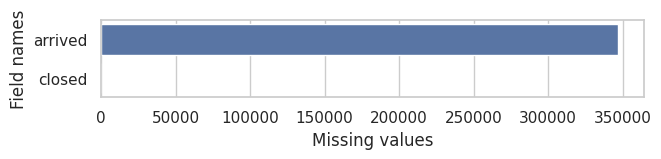

________________________________________________________________________________


,key,created,occured,police_code,patrol,borough,x_coord,y_coord,added,dispatched,arrived,closed,code,description,category
1863798,93474847,2023-03-31,2023-03-31,60,PATROL BORO BKLYN SOUTH,BROOKLYN,990088,154471,2023-03-31 23:59:49,2023-04-01 00:00:12,NaT,2023-04-01 00:13:30,10Y3,INVESTIGATE/POSSIBLE CRIME: SERIOUS/OTHER,Non CIP
1863799,93474848,2023-03-31,2023-03-31,23,PATROL BORO MAN NORTH,MANHATTAN,999657,224608,2023-03-31 23:59:52,2023-03-31 23:59:52,2023-03-31 23:59:52,2023-04-01 01:59:20,75D,VISIBILITY PATROL: DIRECTED,Non CIP


In [25]:
execute("""

DROP TABLE IF EXISTS facts_call;
CREATE TABLE IF NOT EXISTS facts_call (
     key BIGINT PRIMARY KEY,                   ---"CAD_EVNT_ID"   BIGINT,
     created DATE NOT NULL,                    ---"CREATE_DATE"   TEXT,
     occured DATE NOT NULL,                    ---"INCIDENT_DATE" TEXT,
                                               ---"INCIDENT_TIME" TEXT,
     police_code INTEGER NOT NULL,             ---"NYPD_PCT_CD"   TEXT,
     ---LOCATION ---                           ---"BORO_NM"       TEXT,
     patrol_key INTEGER NOT NULL,              ---"PATRL_BORO_NM" TEXT,
     location_key BIGINT NOT NULL,             ---"GEO_CD_X"      BIGINT,
     ---LOCATION ---                           ---"GEO_CD_Y"      BIGINT,
     call_code_key BIGINT NOT NULL,            ---"RADIO_CODE"    TEXT,
     ---CALL CODE ----                         ---"TYP_DESC"      TEXT,
     ---CALL CODE ----                         ---"CIP_JOBS"      TEXT,
     call_times_key BIGINT NOT NULL            ---"ADD_TS"        TEXT,
     ---CALL TIMES ----                        ---"DISP_TS"       TEXT,
     ---CALL TIMES ----                        ---"ARRIVD_TS"     TEXT,
     ---CALL TIMES ----                        ---"CLOSNG_TS"     TEXT,
     ---LOCATION ---                           ---"Latitude"      TEXT,
     ---LOCATION ---                           ---"Longitude"     TEXT
);
""")

execute("""
TRUNCATE TABLE facts_call;
INSERT INTO facts_call (key, created, occured, police_code, patrol_key, location_key, call_code_key, call_times_key)
SELECT
    DISTINCT ON (key)
    r.key AS key, r.created AS created, r.occured AS occured, 
    r.police_code AS police_code, p.id AS patrol_key, l.id AS location_key,
    c.id AS call_code_key, t.key AS call_times_key
FROM
(
    SELECT
        "CAD_EVNT_ID"                      AS key,
        "CREATE_DATE"::DATE                AS created,
        TO_TIMESTAMP(CONCAT(
            "INCIDENT_DATE"::TEXT, ' ', 
            "INCIDENT_TIME"::TEXT), 
            'MM/DD/YYYY HH24:MI:SS')       AS occured,
        ISNULL("NYPD_PCT_CD"::INTEGER, -1) AS police_code,
        ISNULL("BORO_NM", 'UNKWN')         AS borough,
        ISNULL("PATRL_BORO_NM", 'UNKWN')   AS borough_patrol,
        "GEO_CD_X"::INTEGER                AS x_coord,
        "GEO_CD_Y"::INTEGER                AS y_coord,
        ISNULL("RADIO_CODE", 'UNKWN')      AS radio_code,
        ISNULL("TYP_DESC", 'UNKWN')        AS type_desc,
        ISNULL("CIP_JOBS", 'UNKWN')        AS cip_jobs,
        "ADD_TS"::DATE                     AS add_ts, 
        "DISP_TS"::DATE                    AS add_ts, 
        "ARRIVD_TS"::DATE                  AS add_ts, 
        "CLOSNG_TS"::DATE                  AS add_ts
    FROM staging_calls
) AS r
LEFT JOIN dim_location AS l ON 
    l."borough" = r."borough" AND
    l."x_coord" = r."x_coord" AND
    l."y_coord" = r."y_coord"
LEFT JOIN dim_call_times AS t ON t.key = r.key
LEFT JOIN dim_call_code AS c ON
    c.code = r.radio_code AND
    c.description = r.type_desc AND
    c.category = r.cip_jobs
LEFT JOIN dim_precinct_patrol AS p ON
    p.patrol = r.borough_patrol
;
""")

display(select("select * from facts_call;").head(2))
df = select("""
SELECT
    a.key, a.created, a.occured, a.police_code, 
    p.patrol, l.borough, l.x_coord, l.y_coord,
    t.added, t.dispatched, t.arrived, t.closed,
    c.code, c.description, c.category
FROM facts_call a
LEFT JOIN dim_precinct_patrol AS p ON p.id = a.patrol_key
LEFT JOIN dim_location        AS l ON l.id = a.location_key
LEFT JOIN dim_call_times      AS t ON t.key = a.call_times_key
LEFT JOIN dim_call_code       AS c ON c.id = a.call_code_key
ORDER BY a.key
""")
print('FILE RECORDS: {:,}'.format(calls.shape[0])); 
print('DB   RECORDS: {:,}'.format(df.shape[0])); line()
show_uniques_values(df, 'patrol',      2, 11)
show_uniques_values(df, 'code',     4, 11)
show_uniques_values(df, 'borough',     4, 11)
show_uniques_values(df, 'description', 3, 11)
show_uniques_values(df, 'category',    3, 11)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.tail(2))

# <span style='font-family:Verdana;color:red;line-height:40px'>Facts: Arrest</span>
---
[Top](#Project-Summary) | 
[Analysis](#Analysis:-staging_arrests) |
[Arrest Legal](#Dimension:-Arrest-Legal) |
[Location](#Dimension:-Location) |
[Precinct](#Dimension:-Precinct) |
[Quality Check](#Quality-Check:-Arrests)

In [26]:
execute("""
DROP TABLE IF EXISTS facts_arrest;
CREATE TABLE IF NOT EXISTS facts_arrest (
     key BIGINT PRIMARY KEY,            --- "ARREST_KEY"  BIGINT,
     arrested DATE NOT NULL,            --- "ARREST_DATE" TEXT,
     police_key BIGINT NOT NULL,        --- "PD_CD"       TEXT,
     arrest_legal_key BIGINT NOT NULL,  --- "PD_DESC"     TEXT,
     key_cd INTEGER NOT NULL,           --- "KY_CD"       TEXT,
     -- ARREST LEGAL ---                --- "OFNS_DESC"   TEXT,
     -- ARREST LEGAL ---                --- "LAW_CODE"    TEXT,
     -- ARREST LEGAL ---                --- "LAW_CAT_CD"  TEXT,
     location_key BIGINT NOT NULL,      --- "ARREST_BORO" TEXT,
     precinct_key BIGINT NOT NULL,      --- "ARREST_PRECINCT"   BIGINT,
     jurisdiction_code BIGINT NOT NULL  --- "JURISDICTION_CODE" BIGINT
     --- OFFENDER ---                   --- "AGE_GROUP"   TEXT,
     --- OFFENDER ---                   --- "PERP_SEX"    TEXT,
     --- OFFENDER ---                   --- "PERP_RACE"   TEXT,
     --- OFFENDER ---                   --- "X_COORD_CD"  BIGINT,
     --- LOCATION ---                   --- "Y_COORD_CD"  BIGINT,
     --- LOCATION ---                   --- "Latitude"    TEXT,
     --- LOCATION ---                   --- "Longitude"   TEXT,
     --- LOCATION ---                   --- "New Georeferenced Column" TEXT
);
""")

execute("""
--- FACTS: ARRESTS ------------------------------------------------------------------------------
TRUNCATE TABLE facts_arrest;
INSERT INTO facts_arrest (key, arrested, police_key, arrest_legal_key, key_cd, location_key, 
    precinct_key, jurisdiction_code)
SELECT
    DISTINCT ON(r.key)
    r.key, r.arrested, r.police_key, a.id AS arrest_legal_key, r.key_cd, l.id AS location_key, 
    r.precinct_key, r.jurisdiction_code
FROM
(
    SELECT 
        "ARREST_KEY"                  AS key,
        "ARREST_DATE"::DATE           AS arrested,
        ISNULL("PD_CD"::INTEGER, -1)  AS police_key,
        ISNULL("KY_CD"::INTEGER, -1)  AS key_cd,
        ISNULL("PD_DESC",   'UNKWN')  AS description,
        ISNULL("OFNS_DESC", 'UNKWN')  AS offence,
        ISNULL("LAW_CODE",  'UNKWN')  AS code,
        ISNULL("LAW_CAT_CD",'UNKWN')  AS category,
        ISNULL("ARREST_BORO", 'UNKWN') AS borough,
        "ARREST_PRECINCT"::BIGINT     AS precinct_key,
        ISNULL("JURISDICTION_CODE"::INTEGER, -1) AS jurisdiction_code,
        ---ISNULL("AGE_GROUP", 'UNKWN')  AS offender_age,
        ---ISNULL("PERP_SEX",  'UNKWN')  AS offender_sex,
        ---ISNULL("PERP_RACE,  'UNKWN')  AS offender_race,
        "X_COORD_CD"::INTEGER         AS x_coord,
        "Y_COORD_CD"::INTEGER         AS y_coord
        ---"Latitude"                    AS latitude,
        ---"Longitude"                   AS longitude,
        ---ISNULL("New Georeferenced Column", '')  AS point
    FROM staging_arrests
) AS r
LEFT JOIN dim_arrest_legal AS a ON 
    a.description = r.description AND
    a.offence = r.offence AND 
    a.code = r.code AND
    a.category = r.category
LEFT JOIN dim_location AS l ON 
    l."borough" = r."borough" AND
    l."x_coord" = r."x_coord" AND
    l."y_coord" = r."y_coord"
ORDER BY key
;
""")

df = select("""
SELECT
    a.key, a.arrested, a.police_key, a.key_cd, a.precinct_key, p.borough, a.jurisdiction_code,
    o.age, o.sex, o.race, 
    g.description, g.offence, g.code, g.category,
    l.borough AS borough_cd, l.x_coord, l.y_coord, l.point 
FROM facts_arrest a
LEFT JOIN dim_precinct AS p ON p.id = a.precinct_key
LEFT JOIN dim_location AS l ON l.id = a.location_key
LEFT JOIN dim_arrest_legal AS g ON g.id = a.arrest_legal_key
LEFT JOIN dim_offender AS o ON o.key = a.key AND o.source = 'staging_arrests'
ORDER BY a.key
""")
print('FILE RECORDS: {:,}'.format(arrests.shape[0])); 
print('DB   RECORDS: {:,}'.format(df.shape[0])); line
show_uniques_values(df, 'police_key',  8, 10)
show_uniques_values(df, 'key_cd',      8, 10)
show_uniques_values(df, 'borough',     7, 10)
show_uniques_values(df, 'jurisdiction_code',  10, 14)
show_uniques_values(df, 'age',         8, 10)
show_uniques_values(df, 'sex',         4, 10)
show_uniques_values(df, 'race',        3, 10)
show_uniques_values(df, 'description', 3, 10)
show_uniques_values(df, 'offence',     3, 10)
show_uniques_values(df, 'code',        8, 10)
show_missing_values(df.isna().sum(), True, 7, 1);line()
display(df.head(2))

2023-07-10 19:55:48.667: SQL successfully executed: (-1) rows.
2023-07-10 19:55:49.518: SQL successfully executed: (54,576) rows.
(54576) records in (18) field(s)
FILE RECORDS: 54,576
DB   RECORDS: 54,576
police_key : ['-1', '100', '101', '104', '105', '106', '109', '112'] of (218) values.
key_cd     : ['-1', '101', '103', '104', '105', '106', '107', '109'] of (65) values.
borough    : [BRONX, BROOKLYN, MANHATTAN] of (3) values.
jurisdiction_code : ['0', '1', '11', '14', '15', '2', '3', '4', '6', '69'] of (18) values.
age        : [18-24, 25-44, 45-64, 65+, <18] of (5) values.
sex        : [F, M, U] of (3) values.
race       : ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK'] of (7) values.
description : ['A.B.C.,FALSE PROOF OF AGE', 'ACCOSTING,FRAUDULENT', 'ADM.CODE,UNCLASSIFIED MISDEMEA'] of (209) values.
offence    : ['ADMINISTRATIVE CODE', 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED', 'ALCOHOLIC BEVERAGE CONTROL LAW'] of (61) values.
code       : ['ABC0064B00', 'ABC

,key,arrested,police_key,key_cd,precinct_key,borough,jurisdiction_code,age,sex,race,description,offence,code,category,borough_cd,x_coord,y_coord,point
0,261180920,2023-01-01,244,107,75,BROOKLYN,0,18-24,F,BLACK,"BURGLARY,UNCLASSIFIED,UNKNOWN",BURGLARY,PL 1402000,F,K,1017119,183909,POINT (-73.881509 40.671404)
1,261180925,2023-01-01,494,111,107,MANHATTAN,0,25-44,M,BLACK HISPANIC,"STOLEN PROPERTY 2,1,POSSESSION",POSSESSION OF STOLEN PROPERTY,PL 1654502,F,Q,1034513,197590,POINT (-73.81870464 40.70887285)


## <span style='font-family:Verdana;color:navy;line-height:40px'>Data Quality Checks</span>
---
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) | 
[Project Summary](#Project-Summary) |
[Analysis](#Step-2:-Explore-and-Assess-the-Data)|
[Facts](#Facts:-Shooting)
[Quality Check](#Quality-Check:-Shootings)

---
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
## <span style='font-family:Verdana;color:red;line-height:40px'>Quality Check: Shootings</span>
[Shooting](#Shooting) |
[Facts](#Facts:-Shooting) |
[Quality Check](#Quality-Check:-Arrests)

In [27]:
select("""
SELECT
    (SELECT COUNT(*) FROM staging_shootings) AS staging_rows,
    COUNT(r.*) AS facts_rows
FROM(

    SELECT a.*, s.*, 
    o.age AS offender_age, o.sex AS offender_sex, m.flag AS murder_flag, o.race AS offender_race,
    v.age AS victim_age, v.sex AS victim_sex, v.race AS victim_race
    FROM facts_shooting a
    LEFT JOIN dim_location AS l ON l.id = a.location_key
    LEFT JOIN dim_shooting_location AS s ON s.id = a.site_id
    LEFT JOIN dim_offender AS o ON o.key = a.key AND o.source = 'staging_shootings'
    LEFT JOIN dim_victim   AS v ON v.key = a.key
    LEFT JOIN dim_shooting_murder_flag AS m ON m.key = a.key
    ORDER BY a.key
) AS r
;
""").head()

(1) records in (2) field(s)


,staging_rows,facts_rows
0,292,292


## <span style='font-family:Verdana;color:red;line-height:40px'>Quality Check: Calls</span>

In [28]:
select("""
SELECT
    (SELECT COUNT(*) FROM staging_calls) AS staging_rows,
    COUNT(r.*) AS facts_rows
FROM
(
    SELECT
        a.key, a.created, a.occured, a.police_code, 
        p.patrol, l.borough, l.x_coord, l.y_coord,
        t.added, t.dispatched, t.arrived, t.closed,
        c.code, c.description, c.category
    FROM facts_call a
    LEFT JOIN dim_precinct_patrol AS p ON p.id = a.patrol_key
    LEFT JOIN dim_location        AS l ON l.id = a.location_key
    LEFT JOIN dim_call_times      AS t ON t.key = a.call_times_key
    LEFT JOIN dim_call_code       AS c ON c.id = a.call_code_key
    ORDER BY a.key
) AS r
""").head()

(1) records in (2) field(s)


,staging_rows,facts_rows
0,1863800,1863800


## <span style='font-family:Verdana;color:red;line-height:40px'>Quality Check: Arrests</span>
[Arrest](#Arrests) |
[Facts](#Facts:-Arrest) |
[Quality Check](#Quality-Check:-Arrests)

In [29]:
select("""
SELECT
    (SELECT COUNT(*) FROM staging_arrests) AS staging_rows,
    COUNT(r.*) AS facts_arrest
FROM
(
    SELECT
        a.key, a.arrested, a.police_key, a.key_cd, a.precinct_key, p.borough, a.jurisdiction_code,
        o.age, o.sex, o.race, 
        g.description, g.offence, g.code, g.category,
        l.borough AS borough_cd, l.x_coord, l.y_coord, l.point 
    FROM facts_arrest a
    LEFT JOIN dim_precinct AS p ON p.id = a.precinct_key
    LEFT JOIN dim_location AS l ON l.id = a.location_key
    LEFT JOIN dim_arrest_legal AS g ON g.id = a.arrest_legal_key
    LEFT JOIN dim_offender AS o ON o.key = a.key AND o.source = 'staging_arrests'
    ORDER BY a.key
) AS r
""").head()

(1) records in (2) field(s)


,staging_rows,facts_arrest
0,54576,54576


## <span style='font-family:Verdana;color:gray;line-height:40px'>Graph: Shootings & Arrests</span>

---
[Top](#Step-4:-Run-Pipelines-to-Model-the-Data) | 
[Project Summary](#Project-Summary) |
[Staging](#Analysis:-Shootings)

(222) records in (7) field(s)


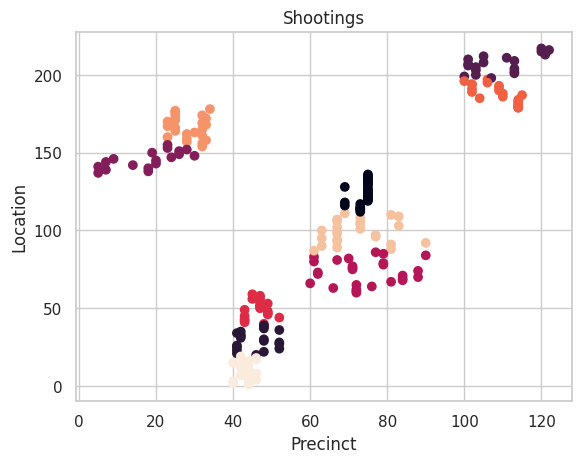

,key,occured,precinct_key,site_id,location_key,jurisdiction_code,murder_flag,Cluster
0,261194183,2023-01-01 05:55:00,47,30,51,0,False,5


(54576) records in (2) field(s)


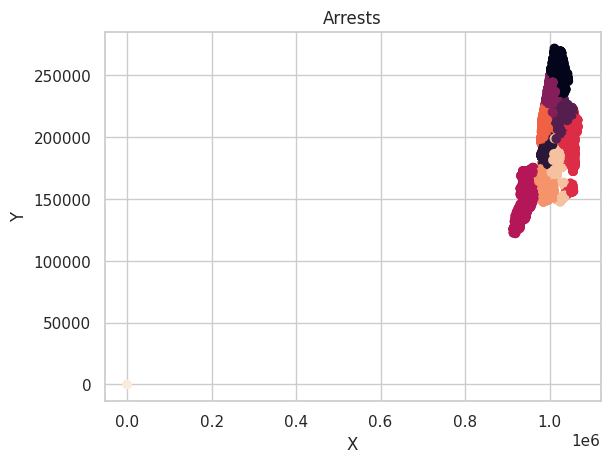

,x_coord,y_coord,Cluster
0,1017119,183909,8


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def show_clasters(sql, x, y, xlabel, ylabel, title, clusters=10, rndstate=45):
    data = select(sql)
    attributes = [x, y]
    X = data[attributes]
    kmeans = KMeans(n_clusters=clusters, random_state=rndstate)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    data['Cluster'] = cluster_labels
    plt.scatter(data[x], data[y], c=data['Cluster'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    display(data.head(1))
shootings = """SELECT """
show_clasters("SELECT * FROM facts_shooting;", 'precinct_key', 'location_key', "Precinct", "Location", "Shootings", 
              10, 20)
show_clasters("SELECT l.x_coord, l.y_coord FROM facts_arrest a LEFT JOIN dim_location AS l ON l.id = a.location_key;", 
              'x_coord', "y_coord", "X", "Y", "Arrests",
             10, 20)

# <span style='font-family:Verdana;color:navy;line-height:40px'>Step 5: Complete Project Write Up</span>
---
[Project Summary](#Project-Summary)

* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

## <span style='font-family:Verdana;color:navy;'>Write up</span>
* <span style='font-family:Verdana;color:red;'>**Data Storage**</span>: For storing your datasets, you can use Amazon S3 (Simple Storage Service). It provides scalable, durable, and highly available object storage for your large datasets, including historical data.</br></br>

* <span style='font-family:Verdana;color:red;'>**ETL Pipelines**</span>: To build ETL (Extract, Transform, Load) pipelines, Apache Airflow is a suitable choice. The Airflow Docker  is designed and used in this excercise. But if the data sources grow in volumen and size, this can be scaled by setting up Airflow cluster using Amazon Elastic Container Service (ECS) or AWS Fargate, which allow to manage and run containerized Airflow tasks.</br></br>

* <span style='font-family:Verdana;color:red;'>**Data Ingestion**</span>: For ingesting the data into the PostgresSQL database, this is tested within the PostgresSQL database installed on a Docker. However another option if the size of the data gets bigger, it can be moved to a Amazon RedShift cluster to enable scalabiltiy. AWS Database Migration Service (DMS) or AWS Glue can also be used as it is a fully manage extract, transform, and load (ETL) service simplifying the process of preparing and loading data into data stores.</br></br>

* <span style='font-family:Verdana;color:red;'>**Data Warehousing**</span>: To implement the staging and STAR model tables the data, this is done wihtin the Docker image PostgresDatabese. As noted above, Amazon Redshift could be utilised to enable fully managed data warehousing service in support of larger volumes of data.</br></br>

* <span style='font-family:Verdana;color:red;'>**Visualization and Analysis**</span>: For data visualization, it really depends on what the data will be used for in the future. An option would be to use Amazon QuickSight business intelligence (BI) service that allows creation of interactive visualizations, dashboards, and reports. QuickSight can also be directly connected to data sources, including Amazon Redshift, to udnertake the analysis and prepare insights.</br></br>

* <span style='font-family:Verdana;color:red;'>**Infrastructure and Scalability**</span>: To ensure scalability and fault tolerance,the optioin is to leverage AWS Elastic Compute Cloud (EC2) or AWS Fargate for running the application components. AWS Auto Scaling can be used to automatically adjust the capacity of the needed resources based on future demand.</br></br>

* <span style='font-family:Verdana;color:red;'>**Security and Compliance**</span>: Security measures such as AWS Identity and Access Management (IAM) will be used for access control,and AWS Key Management Service (KMS) for encryption, and AWS CloudTrail could be used for auditing and compliance purposes.</br></br>

## <span style='font-family:Verdana;color:navy;'>Data Dictionary</span>
[Top](#Project-Summary)

In [31]:
sql = """
SELECT table_name, column_name 
FROM information_schema.columns
WHERE 
    table_name LIKE 'dim%%' -- OR table_name LIKE 'stag%%'
ORDER by table_name, ordinal_position
;
""";
display(select(sql))

(48) records in (2) field(s)


,table_name,column_name
0,dim_arrest_legal,id
1,dim_arrest_legal,description
2,dim_arrest_legal,offence
3,dim_arrest_legal,code
4,dim_arrest_legal,category
5,dim_call_code,id
6,dim_call_code,code
7,dim_call_code,description
8,dim_call_code,category
9,dim_call_times,id


# <span style='font-family:Verdana;color:red;line-height:40px'>Docker</span>

### <span style='font-family:Verdana;color:gray;line-height:40px'>Build Airflow docker image for pipeline test and development</span>
- use Docker instructions below to build image:  `docker build -t <docker dir> .`
---
[Top](#Project-Summary)
    
``` bash
FROM apache/airflow
#2.0.1-python3.8

USER root

# Install apps ..................................................................
RUN apt-get update
RUN apt-get install -y vim
RUN apt-get install -y nano
RUN apt-get install -y curl gnupg
RUN apt-get install -y procps

# Instalacija Postgress .........................................................
RUN apt-get install -y postgresql
RUN apt-get install -y postgresql-client

# Set Australia Easter Time Zone.................................................
RUN ln -sf /usr/share/zoneinfo/Australia/Sydney /etc/localtime

... Postgres & configuration 
RUN sudo service postgresql start
RUN sleep 10

COPY --chown=root:root    root/ /root/
COPY --chown=airflow:root home/airflow/ /home/airflow/
COPY --chown=airflow:root opt/airflow/ /opt/airflow/
COPY --chown=airflow:root home/airflow/bin/postgresql.txt /root/bin/postgresql.sh

RUN . /root/bin/postgresql.sh -p -c airflow

# AIRFLOW .......................................................................
USER airflow

EXPOSE 8888/tcp
EXPOSE 8080/tcp

# pip installs ..................................................................
RUN pip install apache-airflow-providers-postgres
RUN pip install pandas
RUN pip install jupyter
RUN pip install seaborn matplotlib

# START .........................................................................
RUN python -m ipykernel install --user --name=airflow --display-name="aiflow"&
CMD ["standalone"]
```

### <span style='font-family:Verdana;color:gray;line-height:40px'>Login to Docker and configure Airflow</span>
[Project Summary](#Project-Summary)

----
- start docker container 
- login as **root**
    - `docker exec --user root -it <container> /bin/bash`
- start the **postgresql** database
    - `services postgresql start`
- start jupyter notebook 
    - `jupyter notebook --ip=0.0.0.0 --port=8888 &`
- create **user** in postgres and grant  access
---

```sql
    CREATE USER ${user} WITH PASSWORD '${pwd}';
    GRANT ALL PRIVILEGES ON SCHEMA public to ${user};
    
    ALTER USER ${user} CREATEDB;
    CREATE DATABASE ${user};
    GRANT ALL PRIVILEGES ON DATABASE ${user} TO ${user};
    CREATE SCHEMA ${user};
    GRANT USAGE ON SCHEMA ${user} TO ${user};
    GRANT ALL PRIVILEGES ON SCHEMA ${user} TO ${user};
    GRANT ALL PRIVILEGES ON SCHEMA public TO ${user};

    ALTER DEFAULT PRIVILEGES IN SCHEMA public GRANT ALL ON TABLES TO ${user};
    ALTER DEFAULT PRIVILEGES IN SCHEMA ${user} GRANT ALL ON TABLES TO ${user};
    GRANT pg_read_server_files to ${user};
```
---
- replace **sqlite** to **postgres** in `airflow.cfg` to 
    - change the `sql_alchemy_conn` to use postgres instead of sqlite:
        - postgresql+psycopg2://`<username>`:`<password>`@localhost:5432/postgres
- run `airflow db init`
- create `airflow` admin user to log to airflow
```bash
    airflow db init
    airflow users create --username admin \
        --password admin \
        --firstname Admin \
        --lastname Admin \
        --role Admin \
        --email email@domain.com -v
```
- find help if needed `airflow cheatsheet`
- run `jupyter notebook --ip=0.0.0.0  --port=8888 &`


## Resources
- https://www.nyc.gov/site/nypd/stats/stats.page
- https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8
- https://blog.biocomm.ai/2023/05/15/keynote-ai-and-the-future-of-humanity-yuval-noah-harari-at-the-frontiers-forum/
- https://towardsdatascience.com/how-i-redesigned-over-100-etl-into-elt-data-pipelines-c58d3a3cb3c
- https://www.unesco.org/en/artificial-intelligence/recommendation-ethics
- https://github.com/seadawy/Coursera_Capstone/blob/master/Final%20Report.ipynb
- https://github.com/clementmac/data-lake-udacity/blob/master/etl.py
- https://wiki.openstreetmap.org/wiki/API_v0.6
- https://location.foursquare.com/products/places-api/
- https://github.com/seadawy/Coursera_Capstone/blob/master/Project.ipynb
- https://data.cityofnewyork.us/City-Government/Neighborhood-Names-GIS/99bc-9p23
- https://github.com/noiseorigin/ibm-data-science-capstone/blob/master/Capstone%20Project%20Notebook.ipynb

[Top](#Project-Summary)